In [2]:
# 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
plt.rcParams['axes.unicode_minus'] = False
f_path = "/Library/Fonts/Arial Unicode.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

### 목차
- 데이터 탐색
        - 결측치 제거 및 유니크 값 확인
        - 시간에 따른 탐색
        - Amount의 심화 탐색
        - installments(할부) 심화 탐색

In [3]:
# 데이터 탐색하기

In [4]:
# 데이터 불러오기
train = pd.read_csv("train.csv")

In [5]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,NaN,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,NaN,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,NaN,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,NaN,2,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,NaN,0,0


In [6]:
# 변수 8개 관측치는 약 330만개로 관측치에 비해 변수가 적은편이다.
train.shape

(3362796, 8)

In [7]:
# 데이터 정보
# store_id :각 파일에서의 상점 고유 번호.
# date : 거래 일자
# time :거래 시간
# card_id :카드 번호의 hash 값
# amount :매출액
# installments : 할부개월수. 일시불은 빈 문자열
# days_of_week : 요일, 월요일이 0, 일요일은 6
# holiday : 1이면 공휴일, 0이면 공휴일이 아님

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_id      int64  
 1   date          object 
 2   time          object 
 3   card_id       object 
 4   amount        int64  
 5   installments  float64
 6   days_of_week  int64  
 7   holyday       int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [8]:
train.describe()

,store_id,amount,installments,days_of_week,holyday
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00


In [ ]:
# values들의 분포를 그래프로 보겠습니다. 이렇게 봐서는 정확하게 파악하기 어려움

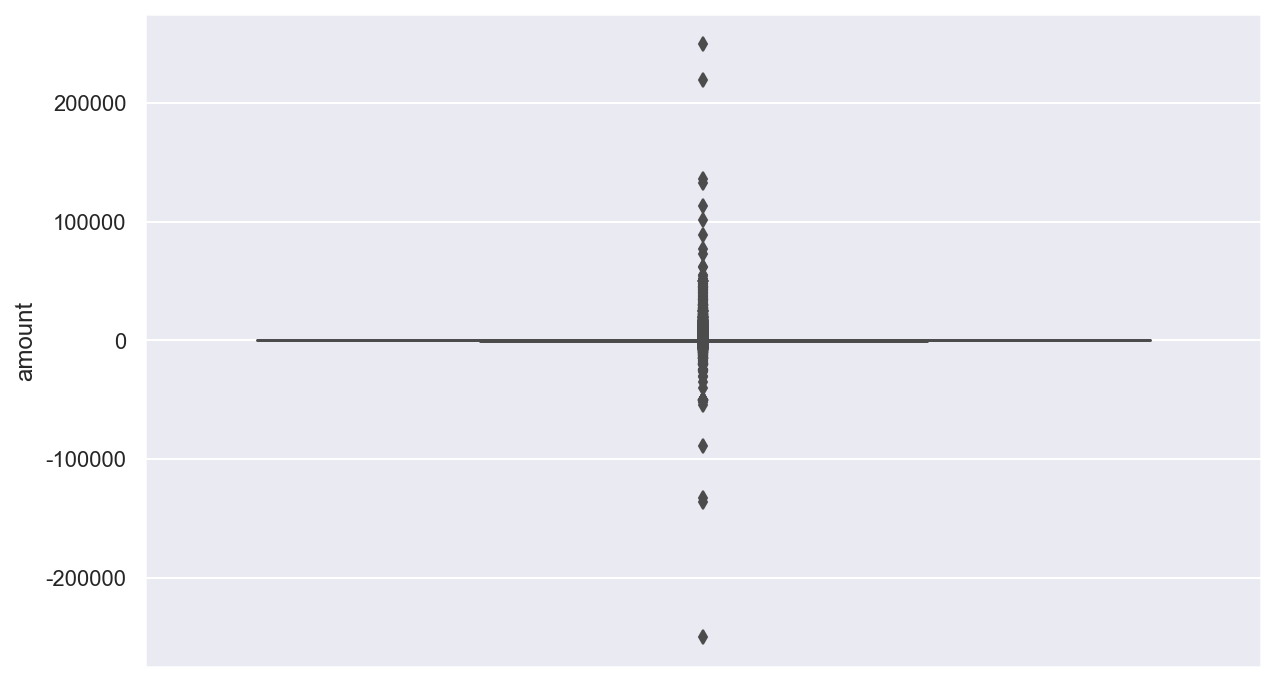

In [11]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.boxplot(y=train["amount"])
plt.show()

In [ ]:
# 이상치를 볼 수 있음 그리고 amount는 환불 때문에 -값이 생긴 것을 볼 수 있다.
# 그래서 환불한 건은 제거해주기로 했다.

In [10]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# sns.boxplot(y=train["amount"], ax=ax[0])
# sns.violinplot(y=train["amount"], ax=ax[1])

In [ ]:
##환볼 노이즈를 제거 하는 함수
def refund_remove(df):
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] ##non_refund 스토어 데이터를 스토어별로 나눔
        divided_data2=refund[refund['store_id']==i] ##refund 스토어 데이터를 나눔 스토어별로 나눔
        
        for neg in divided_data2.to_records()[:]: ##환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] ## 환불 카드 아이디
            refund_datetime=neg['datetime'] ## 환불 시간
            refund_amount=abs(neg['amount']) ## 환불액 절대값을 씌움
                
            ##환불시간 이전의 데이터중 카드이이디와 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            #후보리스트가 있으면,카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['datetime']) ##가장 최근 시간을 구한다
                remove=divided_data[divided_data['datetime']==refund_datetime] ##가장 최근시간
                remove=remove[remove['card_id']==refund_id] ##환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] ##환불액
                divided_data=divided_data.drop(index=remove.index) #인덱스를 통해 제거
                    
        ##제거한데이터를 데이터프레임에 추가한다.
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

In [300]:
# amount의 분포 범위는 넓은데 반해 분포는 한쪽으로 편중되어있다. numpy의 percentile을 이용해 데이터가 차지하는 비율을 확인해보자.

In [14]:
# percentage_99 = np.percentile(train["amount"], 99)
# print(percentage_99)

In [15]:
# percentage_98 = np.percentile(train["amount"], 98)
# print(percentage_98)

In [16]:
# percentage_99 = np.percentile(train["amount"], 99.999)
# print(percentage_99)

In [305]:
# train = train[(train["amount"] >= -50000) & (train["amount"] <= 50000)]

In [351]:
#fig = px.box(train, y="amount")  #plotly로 그래프를 그리려 했지만 용량이 너무커서.....
#fig.show()

In [308]:
# outlier를 제거한 후 그래프. 
# 큰 차이는 없지만 전보다 고르게 분포되어 보인다.
# plt.figure(figsize=(10, 6))
# sns.set_style("darkgrid")
# sns.violinplot(y=train["amount"])
# plt.show()

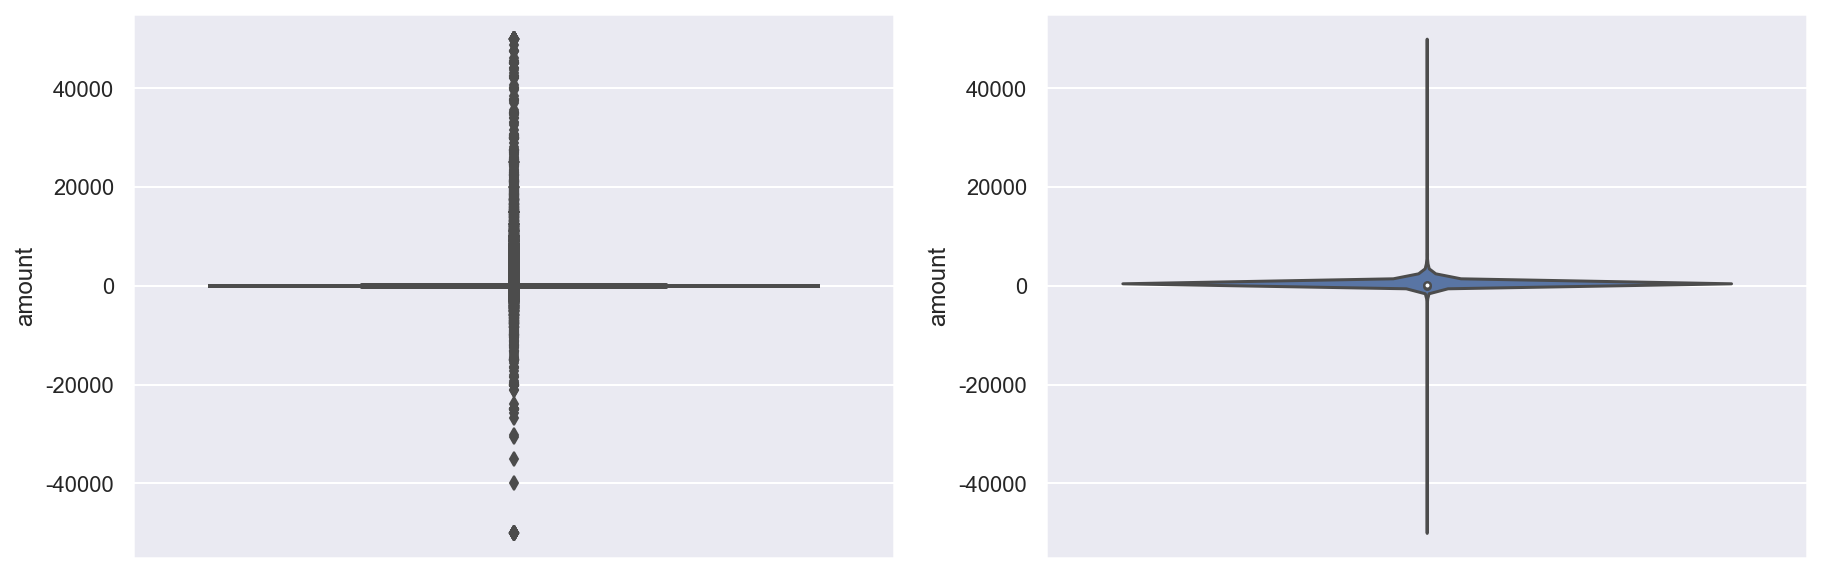

In [309]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y=train["amount"], ax=ax[0])
sns.violinplot(y=train["amount"], ax=ax[1])

In [310]:
# installments 컬럼에 결측치가 3345936개 있는 것 확인

train.count()

store_id        3362774
date            3362774
time            3362774
card_id         3362774
amount          3362774
installments      16847
days_of_week    3362774
holyday         3362774
dtype: int64

In [311]:
# 데이터 확인 결과 결측치가 있는 것을 확인

train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,NaN,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,NaN,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,NaN,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,NaN,2,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,NaN,0,0


In [315]:
# 결측치 그래프로 확인

data = [go.Bar(x=train.columns, y=train.isnull().sum(), name="결측치", opacity = 0.8)]
layout= go.Layout(title= "결측치 개수", xaxis= dict(title=' ', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='결측치 개수', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='결측치 개수')

In [316]:
# 결측치가 있다는 것을 확인했으니 결측치를 채우자!
# installments에서 결측치는 일시불을 의미하니 1로 채우겠습니다.

In [317]:
train["installments"] = train["installments"].fillna(1)

In [318]:
# 결측치를 채웠으니 다시 확인해보자!
train.count()

store_id        3362774
date            3362774
time            3362774
card_id         3362774
amount          3362774
installments    3362774
days_of_week    3362774
holyday         3362774
dtype: int64

In [319]:
# installments가 채워진 것을 확인할 수 있다.
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1.0,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1.0,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1.0,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1.0,2,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1.0,0,0


In [353]:
# 각 컬럼의 상관관계를 한 번 보자
# plt.figure(figsize=(12, 8))
# sns.heatmap(train[train.columns].corr(), cmap="RdBu_r", annot=True)

In [321]:
# 상관관계가 없는 것 같다..... 

In [322]:
# 데이터 유니크 값 개수 확인
# 922522개의 신용카드와 1775개의 상점이 2년 동안 조사된 것을 알 수 있다.
train_unique = []
for i in train.columns.values:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique
unique_train

,Columns,Unique_value
0,store_id,1775
1,date,730
2,time,85924
3,card_id,922520
4,amount,6011
5,installments,17
6,days_of_week,7
7,holyday,2


In [324]:
# 유니크 값 개수 그래프로 확인
data = [go.Bar(x = unique_train['Columns'], y = unique_train['Unique_value'], name = "유니크 값", opacity = 0.8)]
layout= go.Layout(title= "컬럼별 유니크 값 개수", xaxis= dict(title=' ', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='개수', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='컬럼별 유니크 값 개수')

In [325]:
# 월별 매출을 쉽게 하기위해 컬럼 생성
train["year-month"] = train["date"].apply(lambda x: x[:7])

In [326]:
# 나머지 컬럼생성을 쉽게 하기위해 "date" 타입을 변경
train["date"] = train["date"].astype("datetime64[ns]")

In [327]:
# date 타입이 datetime64[ns]로 변경됨
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3362774 entries, 0 to 3362795
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   store_id      int64         
 1   date          datetime64[ns]
 2   time          object        
 3   card_id       object        
 4   amount        int64         
 5   installments  float64       
 6   days_of_week  int64         
 7   holyday       int64         
 8   year-month    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 256.6+ MB


In [328]:
# 우선 2년동안 상점들의 월별 매출을 확인해보겠습니다.
# 현재 데이터로는 월별로 groupby를 할 수 없어 년, 월, 일, 시간, 평일과 주말 컬럼을 새로 만들어 주겠습니다.

In [329]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day


train['hour'] = train['time'].apply(lambda x: x[0:2])
train['hour'] = train['hour'].astype('int')

train['weekend'] = train['days_of_week'].apply(lambda x: 1 if x > 4 else 0)

In [330]:
# 컬럼 생성 확인
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year-month,year,month,day,hour,weekend
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1.0,3,0,2018-07,2018,7,19,17,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1.0,3,0,2018-07,2018,7,19,18,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1.0,6,0,2018-07,2018,7,22,14,1
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1.0,2,0,2018-07,2018,7,25,18,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1.0,0,0,2018-07,2018,7,30,10,0


In [331]:
# 전처리도 했고 컬럼을 생성했으니 이제부터 데이터 분석을 해 보겠습니다.

In [349]:
# 우선 연도별 매출을 살펴보겠습니다. 근데 의미가 없다. 2016년 2018년도 짤림
# yearly_amount = train.groupby("year")["amount"].sum().reset_index()
# yearly_amount

In [348]:
# data = [go.Bar(x=yearly_amount["year"], y=yearly_amount["amount"], name="연 매출", marker_color="blue", opacity = 0.5)]
# layout= go.Layout(title= "연도별 매출", xaxis= dict(title=' ', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='총 매출', ticklen=5, gridwidth=2), showlegend=True)
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='연도별 총 매출')

In [357]:
# 월별 총 매출을 확인해보자
monthly_sales = train.groupby("year-month").sum()["amount"].reset_index(name="monthly_total_amount")
monthly_sales

,year-month,monthly_total_amount
0,2016-08,12756434
1,2016-09,12344477
2,2016-10,13678894
3,2016-11,13536624
4,2016-12,16658969
5,2017-01,15444901
6,2017-02,15371998
7,2017-03,18147107
8,2017-04,18481388
9,2017-05,19134008


In [47]:
# 12월에는 총 매출이 많이 증가하는 것을 볼 수 있다. 연말이라 사람들의 소비가 늘어난 것으로 보인다.
data = [go.Bar(x=monthly_sales["year-month"], y=monthly_sales["monthly_total_amount"], name="Monthly amount", marker_color="limegreen")]
layout= go.Layout(title= "<Monthly sales>", xaxis= dict(title='Month', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Amount', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Monthly sales')

In [355]:
train.groupby("year-month")["amount"].mean().reset_index()

,year-month,amount
0,2016-08,143.190746
1,2016-09,143.756064
2,2016-10,145.435054
3,2016-11,152.511593
4,2016-12,169.921858
5,2017-01,161.152974
6,2017-02,159.930064
7,2017-03,154.190198
8,2017-04,149.238424
9,2017-05,145.495806


In [356]:
# 결제 횟수가 많아지면서 총 매출이 상승함
train.groupby("year-month")["amount"].size().reset_index() # 상관계수 계산하기

,year-month,amount
0,2016-08,89087
1,2016-09,85871
2,2016-10,94055
3,2016-11,88758
4,2016-12,98039
5,2017-01,95840
6,2017-02,96117
7,2017-03,117693
8,2017-04,123838
9,2017-05,131509


In [359]:
tqdm(train.store_id.unique())

NameError: name 'tqdm' is not defined

In [48]:
# 경제 성장률? 물가 상승률? 그래프를 찾아서 같이 보여주면 설득력이 있을 것 같다.

In [49]:
# 계절별 매출은 어떨까? 확인해보자
seasonal_sales = train.groupby("month").sum()["amount"].reset_index(name="seasonal_sales")
seasonal_sales

,month,seasonal_sales
0,1,39519366
1,2,38552769
2,3,46078103
3,4,45536383
4,5,47104656
5,6,45968359
6,7,46422527
7,8,33506425
8,9,34194296
9,10,34797763


In [50]:
# 2분기에 매출이 많이 상승하고 3분기에는 매출이 떨어지는 모습을 보인다. 12월은 연말이라 사람들의 소비가 늘어난 것으로 보임.
data = [go.Bar(x=seasonal_sales["month"], y=seasonal_sales["seasonal_sales"], name="Seasonal sales", marker_color="blue")]
layout= go.Layout(title= "<Seasonal Sales>", xaxis= dict(title='Month', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Seasonal Sales', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Seasonal Sales')

In [51]:
# 요일별로 묶기
train_mon = train[train['days_of_week']==0]
train_tue = train[train['days_of_week']==1]
train_wed = train[train['days_of_week']==2]
train_thu = train[train['days_of_week']==3]
train_fri = train[train['days_of_week']==4]
train_sat = train[train['days_of_week']==5]
train_sun = train[train['days_of_week']==6]

In [52]:
# 요일별 매출
monday_amount = train_mon["amount"].sum()
tuesday_amount = train_tue["amount"].sum()
wednesday_amount = train_wed["amount"].sum()
thursday_amount = train_thu["amount"].sum()
firday_amount = train_fri["amount"].sum()
saturday_amount = train_sat["amount"].sum()
sunday_amount = train_sun["amount"].sum()

In [53]:
# 요일별 매출 데이터프레임
week_amount_data = {"요일":["월요일", "화요일", "수요일", "목요일", "금요일", "토요일", "일요일"],\
        "총매출":[monday_amount, tuesday_amount, wednesday_amount, thursday_amount, firday_amount, saturday_amount, sunday_amount]}
weekly_amount_df = pd.DataFrame(week_amount_data)
weekly_amount_df

,요일,총매출
0,월요일,63751584
1,화요일,68703152
2,수요일,70411719
3,목요일,71061883
4,금요일,77141504
5,토요일,78282779
6,일요일,60726507


In [54]:
# 요일별 총 매출 그래프
data = [go.Scatter(x=weekly_amount_df["요일"], y=weekly_amount_df["총매출"], name="요일별 매출", marker_color="blue")]
layout= go.Layout(title= "요일별 매출", xaxis= dict(title=' ', ticklen=5, zeroline=True, gridwidth=2), yaxis= dict(title='매출', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='요일별 매출')

In [55]:
# 요일별 시간대 총 매출
monday_hourly_amount = train_mon.groupby("hour")["amount"].sum().reset_index()
tuesday_hourly_amount = train_tue.groupby("hour")["amount"].sum().reset_index()
wednsday_hourly_amount = train_wed.groupby("hour")["amount"].sum().reset_index()
thursday_hourly_amount = train_thu.groupby("hour")["amount"].sum().reset_index()
friday_hourly_amount = train_fri.groupby("hour")["amount"].sum().reset_index()
saturday_hourly_amount = train_sat.groupby("hour")["amount"].sum().reset_index()
sunday_hourly_amount = train_sun.groupby("hour")["amount"].sum().reset_index()
sunday_hourly_amount.head()

,hour,amount
0,0,2201868
1,1,1754783
2,2,1232536
3,3,745115
4,4,416342


In [56]:
data = [go.Scatter(x=monday_hourly_amount["hour"][::-1], y=monday_hourly_amount["amount"][::-1], name="Monday", marker_color="black"),
       go.Scatter(x=tuesday_hourly_amount["hour"][::-1], y=tuesday_hourly_amount["amount"][::-1], name="Tuesday", marker_color="yellow"),
       go.Scatter(x=wednsday_hourly_amount["hour"][::-1], y=wednsday_hourly_amount["amount"][::-1], name="Wednsday", marker_color="green"),
       go.Scatter(x=thursday_hourly_amount["hour"][::-1], y=thursday_hourly_amount["amount"][::-1], name="Thursday", marker_color="blue"),
       go.Scatter(x=friday_hourly_amount["hour"][::-1], y=friday_hourly_amount["amount"][::-1], name="Friday", marker_color="purple"),
       go.Scatter(x=saturday_hourly_amount["hour"][::-1], y=saturday_hourly_amount["amount"][::-1], name="Saturday", marker_color="orange"),
       go.Scatter(x=sunday_hourly_amount["hour"][::-1], y=sunday_hourly_amount["amount"][::-1], name="Sunday", marker_color="red")]
layout= go.Layout(title= "요일별 시간대 총매출", xaxis= dict(title='시간', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='매출', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Weekly_mean_slaes')

In [57]:
# 요일별 시간대 한 건당 매출을 확인해보겠습니다.
weekly_mean_slaes1 = train_mon.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes1")
weekly_mean_slaes2 = train_tue.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes2")
weekly_mean_slaes3 = train_wed.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes3")
weekly_mean_slaes4 = train_thu.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes4")
weekly_mean_slaes5 = train_fri.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes5")
weekly_mean_slaes6 = train_sat.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes6")
weekly_mean_slaes7 = train_sun.groupby('hour')['amount'].mean().reset_index(name="weekly_mean_slaes7")

weekly_mean_slaes1.tail()

,hour,weekly_mean_slaes1
19,19,143.686623
20,20,174.737256
21,21,170.553437
22,22,170.887063
23,23,192.119409


In [58]:
# 그래프로 한 건당 매출을 확인해보자!
data = [go.Scatter(x=weekly_mean_slaes1["hour"][::-1], y=weekly_mean_slaes1["weekly_mean_slaes1"][::-1], name="Monday", marker_color="black"),
       go.Scatter(x=weekly_mean_slaes2["hour"][::-1], y=weekly_mean_slaes2["weekly_mean_slaes2"][::-1], name="Tuesday", marker_color="yellow"),
       go.Scatter(x=weekly_mean_slaes3["hour"][::-1], y=weekly_mean_slaes3["weekly_mean_slaes3"][::-1], name="Wednesday", marker_color="green"),
       go.Scatter(x=weekly_mean_slaes4["hour"][::-1], y=weekly_mean_slaes4["weekly_mean_slaes4"][::-1], name="Thursday", marker_color="blue"),
       go.Scatter(x=weekly_mean_slaes5["hour"][::-1], y=weekly_mean_slaes5["weekly_mean_slaes5"][::-1], name="Friday", marker_color="purple"),
       go.Scatter(x=weekly_mean_slaes6["hour"][::-1], y=weekly_mean_slaes6["weekly_mean_slaes6"][::-1], name="Saturday", marker_color="orange"),
       go.Scatter(x=weekly_mean_slaes7["hour"][::-1], y=weekly_mean_slaes7["weekly_mean_slaes7"][::-1], name="Sunday", marker_color="red")]
layout= go.Layout(title= "<Hourly Mean Sales>", xaxis= dict(title='Hour', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Hourly sales', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Weekly_mean_slaes')

In [59]:
# 12시와 18시에 카드 하나당 결제 금액이 낮아지는 것으로 보아 식사 후 각각 계산을 하기 때문인 듯하다.
# 10시와 15시에는 카드 하나당 결제 금액이 높아진다. 한 번에 큰 금액이 결제되는 것

In [60]:
# 일별 구매횟수를 확인해보겠습니다.
daily_count = train.groupby("date")["store_id"].size().reset_index(name="daily_count")
daily_count

,date,daily_count
0,2016-08-01,2808
1,2016-08-02,2792
2,2016-08-03,2990
3,2016-08-04,2920
4,2016-08-05,2958
...,...,...
725,2018-07-27,6731
726,2018-07-28,6402
727,2018-07-29,5622
728,2018-07-30,5838


In [61]:
# 구매횟수가 확연히 떨어지는 날을 확인할 수 있다.
# 구매횟수와 총 매출이 2018년 5월 이후로 떨어지는 것을 확인할 수 있었는데 이는 국제유가와 관련이 있는 것 같다. 미국의 이란 핵 협정 탈퇴로 
# 국제유가 상승
data = [go.Scatter(x=daily_count["date"][::-1], y=daily_count["daily_count"][::-1], name="Daily count", marker_color="red")]
layout= go.Layout(title= "<Number of daily sales>", xaxis= dict(title='Day', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Daily Count', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Number of daily sales')

In [62]:
# 일별 매출합을 보겠습니다.
daily_amount = train.groupby("date")["amount"].sum().reset_index(name="daily_amount")
daily_amount.tail()

,date,daily_amount
725,2018-07-27,943977
726,2018-07-28,863163
727,2018-07-29,685789
728,2018-07-30,774372
729,2018-07-31,845150


In [63]:
# 일일 매출
data = [go.Scatter(x=daily_amount["date"][::-1], y=daily_amount["daily_amount"][::-1], name="Daily Amount", marker_color="blue")]
layout= go.Layout(title= "<Daily sales>", xaxis= dict(title='Day', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Daily Amount', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Daily sales')

In [64]:
# 구매횟수가 떨어지는 날과 연휴를 비교해보자
find_day = ['2016-09-15', '2017-01-28', '2017-10-04', '2018-02-16', '2018-05-06']
train1 = train[(train['date'] == '2016-09-15') | (train['date'] == '2017-01-28') | (train['date'] == '2017-10-04') | (train['date'] == '2018-02-16') | (train['date'] == '2018-05-06')]
train1.groupby('date').agg({'holyday':'mean'})

,holyday
date,
2016-09-15,1
2017-01-28,1
2017-10-04,1
2018-02-16,1
2018-05-06,0


In [65]:
find_day = ['2016-09-15', '2017-01-28', '2017-10-04', '2018-02-16', '2018-05-06']
train1 = train[(train['date'] == '2016-09-15') | (train['date'] == '2017-01-28') | (train['date'] == '2017-10-04') | (train['date'] == '2018-02-16') | (train['date'] == '2018-05-06')]
train1.groupby('date')["holyday"].mean().reset_index()

,date,holyday
0,2016-09-15,1
1,2017-01-28,1
2,2017-10-04,1
3,2018-02-16,1
4,2018-05-06,0


In [66]:
# 구매횟수가 떨어지는 날을 확인해보니 휴일이였다.
# 2016-09-15, 2017-10-04 : 추석, 2017-01-28, 2018-02-16 : 설 
# 추석이나 설 연휴중 당일에는 휴무인 상점이 많아 거래가 준 것으로 보인다.
# 2018-05-06일은 휴일에 포함이 안되어 있는데 2018-05-05일의 대체휴무가 2018-05-07이어서 휴무라고 볼 수 있다.

In [67]:
train[train["amount"] < 0]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year-month,year,month,day,hour,weekend
1,0,2016-12-14,18:05:54,d297bba73f,-5,1.0,2,0,2016-12,2016,12,14,18,0
111,0,2016-12-20,21:06:16,5cb027b003,-108,1.0,1,0,2016-12,2016,12,20,21,0
155,0,2016-12-21,11:16:17,65d5e33f69,-445,3.0,2,0,2016-12,2016,12,21,11,0
165,0,2016-12-21,11:58:13,3c4e290f01,-87,1.0,2,0,2016-12,2016,12,21,11,0
169,0,2016-12-21,12:04:30,3c4e290f01,-50,1.0,2,0,2016-12,2016,12,21,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362257,1798,2018-06-20,13:24:13,e494d92e30,-250,1.0,2,0,2018-06,2018,6,20,13,0
3362259,1798,2018-06-20,13:25:13,e494d92e30,-272,1.0,2,0,2018-06,2018,6,20,13,0
3362260,1798,2018-06-20,13:25:25,e494d92e30,-22,1.0,2,0,2018-06,2018,6,20,13,0
3362677,1799,2018-01-26,15:15:49,4d2e775ae2,-325,1.0,4,0,2018-01,2018,1,26,15,0


In [68]:
# -------------------------------------------------------------- #

In [69]:
# 주중과 주말의 시간당 평균매출 확인해보자
train1 = train[train['weekend']==0]
train2 = train[train['weekend']==1]

hourly_mean_sales1 = train1.groupby('hour')['amount'].mean().reset_index(name="hourly_mean_sales1")
hourly_mean_sales2 = train2.groupby('hour')['amount'].mean().reset_index(name="hourly_mean_sales2")

hourly_mean_sales1.tail()

,hour,hourly_mean_sales1
19,19,144.692497
20,20,178.245561
21,21,179.882941
22,22,175.630298
23,23,193.293111


In [70]:
# 카드 하나당 결제 금액이다. 주중에 점심과 저녁시간에 건당 매출이 낮은 것을 알 수 있는데 각자 계산하는 경우가 많아서인 듯 하다.
# 앞엥서 이미 요일별로 분석해서 그닥 의미는 없어보인다 
data = [go.Scatter(x=hourly_mean_sales1["hour"][::-1], y=hourly_mean_sales1["hourly_mean_sales1"][::-1], name="week_sales", marker_color="blue"),
       go.Scatter(x=hourly_mean_sales2["hour"][::-1], y=hourly_mean_sales2["hourly_mean_sales2"][::-1], name="weekend_sales", marker_color="red")]
layout= go.Layout(title= "<Week VS Weekend sales>", xaxis= dict(title='Hour', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='Payment amount per case', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Week VS Weekend sales')

In [71]:
hourly_sales_count1 = train1.groupby('hour')['amount'].size().reset_index(name="hourly_sales_count1")
hourly_sales_count2 = train2.groupby('hour')['amount'].size().reset_index(name="hourly_sales_count2")

In [72]:
hourly_sales_count1["평일평균구매횟수"] = (hourly_sales_count1["hourly_sales_count1"].values)/5
hourly_sales_count2["주말평균구매횟수"] = (hourly_sales_count2["hourly_sales_count2"].values)/2

In [73]:
hourly_sales_count1.head(1)

,hour,hourly_sales_count1,평일평균구매횟수
0,0,42758,8551.6


In [74]:
hourly_sales_count2.head(1)

,hour,hourly_sales_count2,주말평균구매횟수
0,0,27773,13886.5


In [75]:
# 평일, 주말 결제수
data = [go.Scatter(x=hourly_sales_count1["hour"][::-1], y=hourly_sales_count1["평일평균구매횟수"][::-1], name="평일 결제 횟수", marker_color="blue"),
       go.Scatter(x=hourly_sales_count2["hour"][::-1], y=hourly_sales_count2["주말평균구매횟수"][::-1], name="주말 결제 횟수", marker_color="red")]
layout= go.Layout(title= "평일 VS 주말 구매 횟수", xaxis= dict(title='시간', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='구매횟수', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='평일 주말 구매 횟수')

In [76]:
# 할부분석, 거래취소분석, 정규분포그리기, 클러스터링하기
# 어느시간과 어느요일에 할부를 많이 하는지 거래취소를 많이 하는지

In [77]:
# 할부 
installments_df = train[(train["installments"] > 1)&(train["amount"] > 0)]
installments_df

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year-month,year,month,day,hour,weekend
152,0,2016-12-21,10:48:04,65d5e33f69,445,3.0,2,0,2016-12,2016,12,21,10,0
206,0,2016-12-21,14:26:24,4a8e737d2c,277,2.0,2,0,2016-12,2016,12,21,14,0
311,0,2016-12-21,22:17:30,3f59e8684b,375,3.0,2,0,2016-12,2016,12,21,22,0
651,0,2016-12-24,11:59:37,583d5dd51c,408,3.0,5,0,2016-12,2016,12,24,11,1
689,0,2016-12-24,17:56:05,27822a80ea,553,3.0,5,0,2016-12,2016,12,24,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362429,1799,2017-05-14,21:14:12,54b471994c,1500,3.0,6,0,2017-05,2017,5,14,21,1
3362486,1799,2017-07-19,14:30:10,e47d9a18e4,3850,3.0,2,0,2017-07,2017,7,19,14,0
3362514,1799,2017-08-18,19:08:43,f293d9dc0c,300,2.0,4,0,2017-08,2017,8,18,19,0
3362701,1799,2018-02-19,18:34:25,be98bd957b,1175,3.0,0,0,2018-02,2018,2,19,18,0


In [78]:
# 할부별 빈도수
fig = px.histogram(installments_df, x="installments")
fig.show()

In [79]:
# 어떤 요일에 할부가 가장 많을까?
installments_count_by_day = installments_df.groupby("days_of_week").size().reset_index(name="빈도수")
installments_count_by_day["days_of_week"] = ["월요일", "화요일", "수요일", "목요일", "금요일", "토요일", "일요일"]

In [80]:
data = [go.Bar(x=installments_count_by_day["days_of_week"], y=installments_count_by_day["빈도수"], name="요일별 할부결제 빈도수", marker_color="blue")]
layout= go.Layout(title= "요일별 할부결제 빈도수", xaxis= dict(title=' ', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='빈도수', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='요일별 할부결제 빈도수')

In [81]:
installments1 = installments_df[installments_df["weekend"]==0]
installments2 = installments_df[installments_df["weekend"]==1]

In [82]:
installments_count_by_hour1 = installments1.groupby("hour").size().reset_index(name="평일 시간별 할부결제 빈도수")
installments_count_by_hour2 = installments2.groupby("hour").size().reset_index(name="주말 시간별 할부결제 빈도수")
installments_count_by_hour1.head(2)

,hour,평일 시간별 할부결제 빈도수
0,0,74
1,1,88


In [83]:
installments_count_by_hour1["평일 평균 할부결제 빈도수"] = (installments_count_by_hour1["평일 시간별 할부결제 빈도수"].values)/5 
installments_count_by_hour2["주말 평균 할부결제 빈도수"] = (installments_count_by_hour2["주말 시간별 할부결제 빈도수"].values)/2 
installments_count_by_hour1.head(2)

,hour,평일 시간별 할부결제 빈도수,평일 평균 할부결제 빈도수
0,0,74,14.8
1,1,88,17.6


In [84]:
data = [go.Scatter(x=installments_count_by_hour1["hour"], y=installments_count_by_hour1["평일 평균 할부결제 빈도수"], name="평일", marker_color="blue"),
       go.Scatter(x=installments_count_by_hour2["hour"], y=installments_count_by_hour2["주말 평균 할부결제 빈도수"], name="주말", marker_color="red")]
layout= go.Layout(title= "평일 VS 주말 시간별 할부결제 빈도수", xaxis= dict(title='시간', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='빈도수', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='시간별 할부결제 빈도수')

In [85]:
# 거래취소 건수 33832개
train[train["amount"] < 0].sort_values(by="amount")

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year-month,year,month,day,hour,weekend
929617,370,2018-04-10,14:59:47,d8b799ac0c,-50000,3.0,1,0,2018-04,2018,4,10,14,0
929647,370,2018-07-13,20:10:35,d8b799ac0c,-50000,3.0,4,0,2018-07,2018,7,13,20,0
929649,370,2018-07-13,20:10:36,d8b799ac0c,-50000,3.0,4,0,2018-07,2018,7,13,20,0
929650,370,2018-07-17,19:44:42,d8b799ac0c,-50000,3.0,1,0,2018-07,2018,7,17,19,0
929651,370,2018-07-17,19:44:42,d8b799ac0c,-50000,3.0,1,0,2018-07,2018,7,17,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843100,1497,2016-10-08,17:47:34,b92da52c7f,-1,1.0,5,0,2016-10,2016,10,8,17,1
146689,34,2018-05-09,02:30:27,2285acc03f,-1,1.0,2,0,2018-05,2018,5,9,2,0
1909423,978,2017-02-27,14:30:00,2844b95375,-1,1.0,0,0,2017-02,2017,2,27,14,0
1315207,555,2017-10-17,15:49:00,d2354ab773,-1,1.0,1,0,2017-10,2017,10,17,15,0


In [86]:
# 평균 하루 매출 건수 확인하기

In [ ]:
# 클러스터링 먼저 하자

In [100]:
cluster1 = train.groupby("store_id")["amount"].sum().reset_index()
cluster1.describe()

,store_id,amount
count,1775.000000,1.775000e+03
mean,897.965070,2.761009e+05
std,519.243611,5.315716e+05
min,0.000000,0.000000e+00
25%,448.500000,3.728450e+04
50%,896.000000,1.198840e+05
75%,1346.500000,3.061190e+05
max,1799.000000,9.474601e+06


In [108]:
cluster_50 = cluster1[cluster1["amount"] > 1.198840e+05]
cluster_50

,store_id,amount
0,0,5234611
1,1,147950
2,2,1615060
4,4,270312
5,5,184437
...,...,...
1766,1791,915759
1768,1793,1210907
1769,1794,538364
1770,1795,1319911


In [107]:
cluster_100 = cluster1[cluster1["amount"] <= 1.198840e+05]
cluster_100

,store_id,amount
3,3,62781
7,7,109510
9,9,19760
10,10,9110
14,15,36720
...,...,...
1764,1789,10322
1767,1792,46473
1771,1796,15372
1772,1797,49645


In [110]:
upper50 = cluster_50["store_id"]

In [113]:
cluster_amount1 = train[train["store_id"].isin(upper50)]

In [121]:
cluster_monthly1 = cluster_amount1.groupby("month")["amount"].sum().reset_index()
cluster_monthly1

,month,amount
0,1,37111919
1,2,35895881
2,3,42257978
3,4,41156748
4,5,42216140
5,6,40790132
6,7,41086125
7,8,31871097
8,9,32202993
9,10,32719884


In [116]:
bottom50 = cluster_100["store_id"]

In [117]:
cluster_amount2 = train[train["store_id"].isin(bottom50)]

In [120]:
cluster_monthly2 = cluster_amount2.groupby("month")["amount"].sum().reset_index()

In [123]:
data = [go.Scatter(x=cluster_monthly1["month"], y=cluster_monthly1["amount"], name="상위50%", marker_color="red"),
       go.Scatter(x=cluster_monthly2["month"], y=cluster_monthly2["amount"], name="하위50%", marker_color="blue")]
layout= go.Layout(title= "상위 하위 월별 매출 비교", xaxis= dict(title=' ', ticklen=5, zeroline=False, gridwidth=2), yaxis= dict(title='매출', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='상위 하위 월별 매출 비교')

In [ ]:
# 거래율롤 클러스터링

In [ ]:
train

In [96]:
train_co = train.groupby(['store_id','date'])['amount'].agg("mean").reset_index()
# train1['amount_lag1'] = train1.groupby(['store_id'])['amount'].shift(1)
# train1['amount_lag7'] = train1.groupby(['store_id'])['amount'].shift(7)
# train1 = train1.fillna(0)
train_co.head(60)

,store_id,date,amount
0,0,2016-12-14,0.000000
1,0,2016-12-19,65.000000
2,0,2016-12-20,70.452381
3,0,2016-12-21,89.079787
4,0,2016-12-22,80.630872
5,0,2016-12-23,79.735484
6,0,2016-12-24,103.993197
7,0,2016-12-25,95.225131
8,0,2016-12-26,83.584906
9,0,2016-12-27,94.635417


In [179]:
train[train["amount"] == 2]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
360,0,2016-12-22,13:38:28,ad5c68ef8b,2,NaN,3,0
469,0,2016-12-22,23:24:09,ac9b7a6807,2,NaN,3,0
818,0,2016-12-25,13:28:25,5e91ae336f,2,NaN,6,1
2171,0,2017-01-05,21:02:31,47099fda41,2,NaN,3,0
6442,0,2017-02-14,15:26:02,4529fbdceb,2,NaN,1,0
...,...,...,...,...,...,...,...,...
3339948,1793,2018-01-08,19:09:08,0bcd6461a6,2,NaN,0,0
3346759,1793,2018-06-17,11:58:09,1842462740,2,NaN,6,0
3347122,1793,2018-06-27,11:26:04,6ab30db720,2,NaN,2,0
3358001,1795,2018-06-02,14:25:40,24dd1722b1,2,NaN,5,0
